In [1]:
# --- Core Libraries ---
import pandas as pd
import numpy as np
import os, sys, json, tempfile, pathlib, subprocess, re, time
from tqdm.auto import tqdm

# --- Biophysics and RNA Tools ---
# import RNA 
from scipy.spatial.transform import Rotation as R
from scipy.spatial.distance import cdist

# --- PyTorch for Neural Network ---
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import joblib

# --- Visualization and Metrics ---
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

# --- Energy imports ---
from scipy.spatial.distance import cdist
from typing import Dict, List, Tuple, Optional

# --- Notebook Settings ---
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set_theme(style="whitegrid")
tqdm.pandas()

In [2]:
# --- Configuration ---
MODEL_CONFIG = {
    'ProteinX': {
        'predictions_path': '/home/max/Documents/Standford_3DRNA_PredictionData/Protenix_Baseline_Train/submission.csv',
        'confidences_path': '/home/max/Documents/Standford_3DRNA_PredictionData/Protenix_Baseline_Train/confidence.csv',
        'ranking_path': '/home/max/Documents/Standford_3DRNA_PredictionData/Protenix_Baseline_Train/ranking_scores.csv' # Special file for ProteinX
    },
    'DrFo2': {
        'predictions_path': '/home/max/Documents/Standford_3DRNA_PredictionData/DRfold2_Baseline_train/submission.csv',
        'confidences_path': '/home/max/Documents/Standford_3DRNA_PredictionData/DRfold2_Baseline_train/confidence.csv',
        'ranking_path': None # DrFo2 doesn't have this
    },
    'Ribonanza': {
        'predictions_path': '/home/max/Documents/Standford_3DRNA_PredictionData/Ribonanza_Baseline_Train/ribonanzanet2_submission_with_confidence_train.csv',
        'confidences_path': '/home/max/Documents/Standford_3DRNA_PredictionData/Ribonanza_Baseline_Train/ribonanzanet2_submission_with_confidence_train.csv',
        'ranking_path': None # Ribonanza doesn't have a separate ranking file
    }
}

# Paths to the ground truth and sequence information
SEQUENCES_PATH = '/home/max/Documents/Protenix-KaggleRNA3D/data/stanford-rna-3d-folding/train_sequences_filtered.csv'
LABELS_PATH = '/home/max/Documents/Protenix-KaggleRNA3D/data/stanford-rna-3d-folding/train_labels_filtered.csv'

# Constants
NUM_PREDICTIONS_PER_MODEL = 5
NUCLEOTIDES = ['A', 'C', 'G', 'U']

In [3]:
# --- Data Loading and Pre-processing ---

print("--- Loading and Verifying Input Data ---")

# --- Step 1: Load common sequence and label files ---
try:
    df_sequences = pd.read_csv(SEQUENCES_PATH)
    df_labels = pd.read_csv(LABELS_PATH)
    
    print(f"✅ Loaded sequence data: {df_sequences.shape}")
    print(f"✅ Loaded label data: {df_labels.shape}\n")

except FileNotFoundError as e:
    print(f"FATAL ERROR: Cannot load base files: {e}.")
    print("Please check SEQUENCES_PATH and LABELS_PATH in the configuration cell.")

# --- Step 2: Load data for each model based on its configuration ---
data_dfs = {}
for model_name, config in MODEL_CONFIG.items():
    print(f"--- Processing model: {model_name} ---")
    try:
        is_combined_file = (config['predictions_path'] == config['confidences_path'])

        if is_combined_file and model_name == 'Ribonanza':
            # --- Special Handling for Ribonanza's combined format ---
            print("Detected combined Ribonanza format. Pre-processing...")
            df_raw = pd.read_csv(config['predictions_path'])
            
            # Create the predictions dataframe
            pred_cols = ['ID', 'resname', 'resid'] + [col for col in df_raw.columns if col.startswith(('x_', 'y_', 'z_'))]
            data_dfs[f'{model_name}_preds'] = df_raw[pred_cols].copy()
            
            # Create and rename the confidences dataframe
            conf_cols = ['ID', 'resname', 'resid'] + [f'confidence_{i}' for i in range(1, NUM_PREDICTIONS_PER_MODEL + 1)]
            rename_dict = {f'confidence_{i}': f'plddt_{i}' for i in range(1, NUM_PREDICTIONS_PER_MODEL + 1)}
            data_dfs[f'{model_name}_conf'] = df_raw[conf_cols].copy().rename(columns=rename_dict)
            
            print("✅ Ribonanza data successfully processed.")

        else:
            # --- Standard Handling for separate files (ProteinX, DrFo2) ---
            data_dfs[f'{model_name}_preds'] = pd.read_csv(config['predictions_path'])
            data_dfs[f'{model_name}_conf'] = pd.read_csv(config['confidences_path'])
            print("✅ Loaded separate prediction and confidence files.")

        # Load optional ranking file
        if config.get('ranking_path'):
            data_dfs[f'{model_name}_rank'] = pd.read_csv(config['ranking_path'])
            print("✅ Loaded optional ranking file.")

        # Display heads for verification
        print(f"  - Predictions head for {model_name}:")
        display(data_dfs[f'{model_name}_preds'].head(2))
        print(f"  - Confidences head for {model_name}:")
        display(data_dfs[f'{model_name}_conf'].head(2))

    except FileNotFoundError as e:
        print(f"Error loading files for {model_name}: {e}. Please check paths in MODEL_CONFIG.")
    except Exception as e:
        print(f"An unexpected error occurred while loading data for {model_name}: {e}")

print("\n--- ✅ Initial Data Loading and Pre-processing Complete ---")

--- Loading and Verifying Input Data ---
✅ Loaded sequence data: (760, 5)
✅ Loaded label data: (49687, 6)

--- Processing model: ProteinX ---
✅ Loaded separate prediction and confidence files.
✅ Loaded optional ranking file.
  - Predictions head for ProteinX:


,ID,resname,resid,x_1,y_1,z_1,x_2,y_2,z_2,x_3,y_3,z_3,x_4,y_4,z_4,x_5,y_5,z_5
0,1SCL_A_1,G,1,16.970413,-4.670355,-9.018064,10.486027,-13.865038,12.937576,2.908497,-6.447174,-18.863068,5.535280,16.883900,10.312805,-10.258783,-17.872894,0.623533
1,1SCL_A_2,G,2,15.244921,-7.541238,-4.707215,8.489288,-15.206691,8.009735,3.233741,-9.686610,-14.432230,9.314147,13.212024,8.888163,-5.246715,-17.285484,2.851788


  - Confidences head for ProteinX:


,ID,resname,resid,plddt_1,plddt_2,plddt_3,plddt_4,plddt_5
0,1SCL_A_1,G,1,88.5,88.5,88.5,88.5,88.5
1,1SCL_A_2,G,2,92.0,92.0,92.0,92.0,92.0


--- Processing model: DrFo2 ---
✅ Loaded separate prediction and confidence files.
  - Predictions head for DrFo2:


,ID,resname,resid,x_1,y_1,z_1,x_2,y_2,z_2,x_3,y_3,z_3,x_4,y_4,z_4,x_5,y_5,z_5
0,1SCL_A_1,G,1,-12.274610,19.907804,-3.127253,-9.209579,15.719687,-6.634937,-7.976545,16.119173,-11.591087,-0.032608,-18.876467,6.583105,-9.322432,-15.552121,11.254700
1,1SCL_A_2,G,2,-9.351652,19.744017,2.109739,-8.197619,16.321600,-0.804764,-5.482233,17.419617,-6.110267,-4.998965,-17.499321,3.518940,-9.056844,-10.724106,14.626364


  - Confidences head for DrFo2:


,ID,plddt_1,plddt_2,plddt_3,plddt_4,plddt_5
0,1SCL_A_1,0.415464,0.398302,0.409476,0.436324,0.432180
1,1SCL_A_2,0.461152,0.446779,0.462464,0.490731,0.485669


--- Processing model: Ribonanza ---
Detected combined Ribonanza format. Pre-processing...
✅ Ribonanza data successfully processed.
  - Predictions head for Ribonanza:


,ID,resname,resid,x_1,y_1,z_1,x_2,y_2,z_2,x_3,y_3,z_3,x_4,y_4,z_4,x_5,y_5,z_5
0,1SCL_A_1,G,1,15.348422,10.997616,-11.534798,3.308533,10.459855,19.488457,5.946423,15.54261,-14.663122,5.960367,12.393194,-16.763954,-20.98747,-7.266438,2.338508
1,1SCL_A_2,G,2,20.433796,10.614480,-7.886449,1.387454,5.994024,23.648623,3.058160,20.12456,-12.344646,10.572418,15.876827,-14.417734,-20.40904,-10.174376,8.315649


  - Confidences head for Ribonanza:


,ID,resname,resid,plddt_1,plddt_2,plddt_3,plddt_4,plddt_5
0,1SCL_A_1,G,1,0.799762,0.659163,0.429994,0.381455,0.728176
1,1SCL_A_2,G,2,0.799762,0.659163,0.429994,0.381455,0.728176



--- ✅ Initial Data Loading and Pre-processing Complete ---


In [4]:
def get_coords(df, pred_idx):
    """Extracts x, y, z coordinates for a specific prediction index."""
    return df[[f'x_{pred_idx}', f'y_{pred_idx}', f'z_{pred_idx}']].values

def calculate_radius_of_gyration(coords):
    center_of_mass = np.mean(coords, axis=0)
    return np.sqrt(np.mean(np.sum((coords - center_of_mass)**2, axis=1)))

def calculate_rmsd(coords1, coords2):
    if coords1.shape != coords2.shape: return np.nan
    coords1_centered = coords1 - coords1.mean(axis=0)
    coords2_centered = coords2 - coords2.mean(axis=0)
    rotation, rmsd = R.align_vectors(coords1_centered, coords2_centered)
    return rmsd

USALIGN_PATH = "/home/max/Documents/Protenix-KaggleRNA3D/af3-dev/USalign/USalign"
TEMP_DIR = "./temp_pdb/"
os.makedirs(TEMP_DIR, exist_ok=True)

# --- Functions for TM-Score ---

def parse_tmscore_output(output):
    """Your exact parsing function."""
    tm_score_match = re.findall(r'TM-score=\s+([\d.]+)', output)
    if len(tm_score_match) > 1:
        return float(tm_score_match[1])
    return np.nan

def write_target_line(atom_name, atom_serial, residue_name, chain_id, residue_num,
                      x_coord, y_coord, z_coord, occupancy=1.0, b_factor=0.0, atom_type='C'):
    """
    A corrected PDB line writer that strictly adheres to the PDB format specification.
    This prevents parsing errors and segmentation faults in external tools like USalign.
    """
    # Atom name should be space-padded on the left if < 4 characters.
    # Ex: ' CA ' or ' C1''
    atom_name_padded = f" {atom_name.ljust(3)}" if len(atom_name) < 4 else atom_name

    line = (
        f"ATOM  {atom_serial:5d} {atom_name_padded:<4s} {residue_name:<3s} {chain_id}"
        f"{residue_num:4d}    {x_coord:8.3f}{y_coord:8.3f}{z_coord:8.3f}"
        f"{occupancy:6.2f}{b_factor:6.2f}          {atom_type:>2s}  \n"
    )
    return line

def write2pdb(df: pd.DataFrame, xyz_id: int, target_path: str):
    """Your exact PDB writer function."""
    resolved_cnt = 0
    written_resids = set()
    with open(target_path, 'w') as f:
        for _, row in df.iterrows():
            resid = int(row['resid'])
            if resid in written_resids: continue
            
            x = row[f'x_{xyz_id}']
            y = row[f'y_{xyz_id}']
            z = row[f'z_{xyz_id}']
            if pd.notna(x) and x > -1e17:
                resolved_cnt += 1
                f.write(write_target_line(
                    atom_name="C1'", atom_serial=resid,
                    residue_name=row['resname'], chain_id='A',
                    residue_num=resid,
                    x_coord=x, y_coord=y, z_coord=z
                ))
                written_resids.add(resid)
    return resolved_cnt


def calculate_ground_truth_tm(pred_df, pred_idx, native_df):
    """Calculates the true TM-score using your exact logic."""
    best_tm_for_this_pred = 0.0
    pred_path = os.path.join(TEMP_DIR, 'predicted.pdb')
    native_path = os.path.join(TEMP_DIR, 'native.pdb')
    
    n_pred = write2pdb(pred_df, pred_idx, pred_path)
    if n_pred == 0: return 0.0

    native_indices = sorted(int(c.split('_')[1]) for c in native_df.columns if c.startswith('x_'))
    for nat_idx in native_indices:
        n_nat = write2pdb(native_df, nat_idx, native_path)
        if n_nat > 0:
            cmd = f'{USALIGN_PATH} {pred_path} {native_path} -atom " C1\'"'
            output = os.popen(cmd).read()
            tm = parse_tmscore_output(output)
            if tm is not None and tm > best_tm_for_this_pred:
                best_tm_for_this_pred = tm
    return best_tm_for_this_pred


In [5]:
from scipy.spatial.distance import cdist
from typing import Dict
import numpy as np

class RNAEnergyScorer:
    def __init__(self, clash_penalty: float = 10.0):
        self.CLASH_PENALTY = clash_penalty
        self.VDW_RADIUS_C1 = 1.7
        self.SOLVATION_CUTOFF = 6.0
        self.BASE_PAIR_CUTOFF = 4.5
        self.BASE_PAIR_ENERGIES = {
            ('A', 'U'): -2.0, ('U', 'A'): -2.0,
            ('G', 'C'): -3.0, ('C', 'G'): -3.0,
            ('G', 'U'): -1.5, ('U', 'G'): -1.5,
        }

    def _calculate_vdw_energy(self, coords: np.ndarray) -> float:
        if coords.shape[0] < 2:
            return 0.0

        distances = cdist(coords, coords)
        sigma = self.VDW_RADIUS_C1 * 2
        r = distances[np.triu_indices_from(distances, k=1)]
        r = r[r > 0.1]

        clashes = np.sum(r < 1.0) * self.CLASH_PENALTY

        ratio = sigma / r
        repulsive_term = np.sum(np.minimum(ratio**12, 1e6))
        attractive_term = np.sum(ratio**6)

        return (repulsive_term - attractive_term) + clashes

    def _calculate_solvation_energy(self, coords: np.ndarray) -> float:
        if coords.shape[0] < 2:
            return 0.0

        distances = cdist(coords, coords)
        neighbor_counts = np.sum((distances > 0) & (distances < self.SOLVATION_CUTOFF), axis=1)
        exposure_factors = 1.0 - np.minimum(neighbor_counts, 12) / 12.0
        return -np.sum(exposure_factors)

    def _calculate_base_pair_energy(self, sequence: str, coords: np.ndarray) -> float:
        if len(sequence) != coords.shape[0]:
            return 0.0

        energy = 0.0
        distances = cdist(coords, coords)

        for i in range(len(sequence)):
            potential_partners = np.where(
                (distances[i] < self.BASE_PAIR_CUTOFF) & (np.abs(np.arange(len(sequence)) - i) > 2)
            )[0]

            for j in potential_partners:
                if i >= j:
                    continue
                pair = (sequence[i], sequence[j])
                if pair in self.BASE_PAIR_ENERGIES:
                    weight = 1.0 - (distances[i, j] / self.BASE_PAIR_CUTOFF)
                    energy += self.BASE_PAIR_ENERGIES[pair] * weight
        return energy

    def calculate_all_energies(self, sequence: str, coords: np.ndarray) -> Dict[str, float]:
        if coords.shape[0] == 0:
            return {'e_vdw': 0.0, 'e_solvation': 0.0, 'e_base_pair': 0.0}

        return {
            'e_vdw': self._calculate_vdw_energy(coords),
            'e_solvation': self._calculate_solvation_energy(coords),
            'e_base_pair': self._calculate_base_pair_energy(sequence, coords)
        }

def extract_energy_features(sequence: str, coords: np.ndarray, scorer: RNAEnergyScorer) -> Dict[str, float]:
    if coords.shape[0] == 0 or len(sequence) == 0:
        return {
            'e_vdw': 0.0, 'e_solvation': 0.0, 'e_base_pair': 0.0,
            'e_balance': 0.0, 'e_attractive_per_res': 0.0, 'e_repulsive_per_res': 0.0
        }

    energies = scorer.calculate_all_energies(sequence, coords)
    e_attractive = energies['e_solvation'] + energies['e_base_pair']
    e_repulsive = energies['e_vdw']

    return {
        'e_vdw': e_repulsive,
        'e_solvation': energies['e_solvation'],
        'e_base_pair': energies['e_base_pair'],
        'e_balance': e_attractive / (e_repulsive + 1e-6),
        'e_attractive_per_res': e_attractive / len(sequence),
        'e_repulsive_per_res': e_repulsive / len(sequence)
    }


In [6]:
class MetaLearnerNN(nn.Module):
    def __init__(self, input_features):
        """
        Initializes the Neural Network architecture.
        
        Args:
            input_features (int): The number of input features for the model.
        """
        super(MetaLearnerNN, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(input_features, 64),
            nn.ReLU(),
            nn.Dropout(0.4),
            
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.4),
            
            nn.Linear(32, 16),
            nn.ReLU(),
            
            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        """The forward pass of the model."""
        return self.layers(x)


In [7]:
class RNADatasetWithSource(Dataset):
    def __init__(self, features_df, labels_series, source_series):
        self.features = torch.tensor(features_df.values, dtype=torch.float32)
        self.labels = torch.tensor(labels_series.values, dtype=torch.float32).unsqueeze(1)
        # Ensure sources are also reset with the same index as features/labels
        self.sources = torch.tensor(source_series.reset_index(drop=True).values, dtype=torch.long)
        
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx], self.sources[idx]

In [8]:
import pandas as pd
import numpy as np
import os
from tqdm.auto import tqdm
from scipy.spatial.transform import Rotation as R
from scipy.spatial.distance import cdist
from sklearn.cluster import DBSCAN

print("--- Starting Final Feature Generation ---")

# Initialize the custom energy scorer you provided
energy_scorer = RNAEnergyScorer()
meta_data_rows = []

# Helper function to compute the RMSD matrix for clustering
def calculate_pairwise_rmsd_matrix(coords_dict: Dict) -> (np.ndarray, list):
    candidate_keys = list(coords_dict.keys())
    coords_list = [coords_dict[key] for key in candidate_keys]
    n = len(candidate_keys)
    rmsd_matrix = np.zeros((n, n))
    
    for i in range(n):
        for j in range(i + 1, n):
            # Ensure coordinates are valid and match in shape before calculating RMSD
            if coords_list[i].shape[0] > 0 and coords_list[i].shape == coords_list[j].shape:
                rmsd = calculate_rmsd(coords_list[i], coords_list[j])
                rmsd_matrix[i, j] = rmsd
                rmsd_matrix[j, i] = rmsd
            else:
                # Assign a large distance if shapes mismatch or coords are empty, marking them as dissimilar
                rmsd_matrix[i, j] = 999.0
                rmsd_matrix[j, i] = 999.0
                
    return rmsd_matrix, candidate_keys

# Main loop through each sequence
for _, sequence_row in tqdm(df_sequences.iterrows(), total=len(df_sequences), desc="Processing Targets"):
    target_id = sequence_row['target_id']
    sequence = sequence_row['sequence']
    
    native_df_for_target = df_labels[df_labels['ID'].str.startswith(f"{target_id}_")].copy()
    if native_df_for_target.empty:
        continue

    # Pre-calculate all 15 candidate coordinates for the target
    all_candidate_coords = {}
    for model_name in MODEL_CONFIG:
        df_pred = data_dfs[f'{model_name}_preds']
        target_preds = df_pred[df_pred['ID'].str.startswith(f"{target_id}_")]
        if target_preds.empty: continue
        for i in range(1, NUM_PREDICTIONS_PER_MODEL + 1):
            coords = get_coords(target_preds, i)
            all_candidate_coords[f'{model_name}_{i}'] = coords

    # Perform clustering analysis once per target based on structural similarity
    cluster_info = {}
    if len(all_candidate_coords) > 1:
        rmsd_matrix, candidate_keys = calculate_pairwise_rmsd_matrix(all_candidate_coords)
        # DBSCAN groups together points that are closely packed together (low RMSD)
        dbscan = DBSCAN(eps=7.5, min_samples=2, metric='precomputed', n_jobs=-1)
        cluster_labels = dbscan.fit_predict(rmsd_matrix)
        num_clusters_found = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
        labels_series = pd.Series(cluster_labels)
        cluster_sizes = labels_series.value_counts().to_dict()
        
        for k_idx, key in enumerate(candidate_keys):
            label = cluster_labels[k_idx]
            cluster_info[key] = {
                'cluster_label': label,
                'is_outlier': 1 if label == -1 else 0,
                'cluster_size': cluster_sizes.get(label, 0),
                'num_clusters_total': num_clusters_found
            }

    # Loop through each of the 15 candidates to generate its feature row
    for model_name, config in MODEL_CONFIG.items():
        df_pred = data_dfs[f'{model_name}_preds']
        df_conf = data_dfs[f'{model_name}_conf']
        
        pred_df_for_target = df_pred[df_pred['ID'].str.startswith(f"{target_id}_")].copy()
        target_confs = df_conf[df_conf['ID'].str.startswith(f"{target_id}_")].copy()
        if pred_df_for_target.empty: continue
        
        df_rank = data_dfs.get(f'{model_name}_rank')
        target_rank = df_rank[df_rank['target_id'] == target_id] if df_rank is not None else None

        for i in range(1, NUM_PREDICTIONS_PER_MODEL + 1):
            candidate_key = f'{model_name}_{i}'
            if f'plddt_{i}' not in target_confs.columns or candidate_key not in all_candidate_coords:
                continue
            
            features = {'target_id': target_id, 'model_source': model_name, 'prediction_index': i}
            
            # --- Base Features ---
            features['sequence_length'] = len(sequence)
            for nuc in NUCLEOTIDES: features[f'percent_{nuc}'] = sequence.count(nuc) / len(sequence)

            plddt_scores = target_confs[f'plddt_{i}'].values
            features['std_plddt'] = np.std(plddt_scores) # Identified as more important than the mean
            
            if target_rank is not None and not target_rank.empty:
                features.update({'ptm': target_rank.iloc[0].get(f'ptm_{i}', 0),
                                 'ranking_score': target_rank.iloc[0].get(f'ranking_score_{i}', 0)})
            else:
                features.update({'ptm': 0, 'ranking_score': 0})

            # --- Structural, Ensemble, and Engineered Features ---
            candidate_coords = all_candidate_coords[candidate_key]
            if candidate_coords is None or candidate_coords.shape[0] == 0: continue
            
            # Ensemble features
            rmsd_to_others = [calculate_rmsd(candidate_coords, other_coords) for key, other_coords in all_candidate_coords.items() if key != candidate_key]
            features['avg_rmsd_to_others'] = np.nanmean(rmsd_to_others)

            info = cluster_info.get(candidate_key, {})
            features['is_outlier'] = info.get('is_outlier', 1)
            features['cluster_size'] = info.get('cluster_size', 0)
            features['num_clusters_total'] = info.get('num_clusters_total', 0)
            
            # Normalized structural feature
            if features['sequence_length'] > 0:
                features['rog_normalized'] = calculate_radius_of_gyration(candidate_coords) / np.sqrt(features['sequence_length'])
            else:
                features['rog_normalized'] = 0.0

            # --- Model-Specific Interaction Features ---
            # Create interacted features for the most important base metrics
            base_plddt_std = features['std_plddt']
            base_rog_norm = features['rog_normalized']
            base_percent_low_conf = np.mean(plddt_scores < 70)

            for source in MODEL_CONFIG.keys():
                features[f'std_plddt_x_{source}'] = 0.0
                features[f'rog_norm_x_{source}'] = 0.0
                features[f'low_conf_x_{source}'] = 0.0
            
            features[f'std_plddt_x_{model_name}'] = base_plddt_std
            features[f'rog_norm_x_{model_name}'] = base_rog_norm
            features[f'low_conf_x_{model_name}'] = base_percent_low_conf

            # --- Final Energy Features (using your provided class) ---
            try:
                energy_features = extract_energy_features(sequence, candidate_coords, energy_scorer)
                features.update(energy_features)
            except Exception as e:
                print(f"Warning: Energy calculation failed for {candidate_key}: {e}")
                null_energy = {'e_vdw': 0.0, 'e_solvation': 0.0, 'e_base_pair': 0.0,
                               'e_balance': 0.0, 'e_attractive_per_res': 0.0, 'e_repulsive_per_res': 0.0}
                features.update(null_energy)
            
            # --- Target Variable ---
            tm_score = calculate_ground_truth_tm(pred_df_for_target, i, native_df_for_target)
            features['tm_score'] = tm_score
            
            meta_data_rows.append(features)

# --- Finalize DataFrame ---
df_meta = pd.DataFrame(meta_data_rows)
model_mapping = {name: i for i, name in enumerate(MODEL_CONFIG.keys())}
df_meta['model_source'] = df_meta['model_source'].map(model_mapping)
df_meta.fillna(df_meta.median(numeric_only=True), inplace=True)

print("\n--- Final Feature Set Generation Complete ---")
print(f"Total features for model training: {len(df_meta.columns) - 4}") # -4 for id, model_str, index, score
print("\nDataFrame Columns:")
print(df_meta.columns.tolist())

df_meta.to_csv('meta_learner_training_final.csv', index=False)
print("\n✅ Successfully saved the final meta-learner data.")

--- Starting Final Feature Generation ---


Processing Targets:   0%|          | 0/760 [00:00<?, ?it/s]

Sequence is too short <3!: ./temp_pdb/native.pdb
Sequence is too short <3!: ./temp_pdb/native.pdb
Sequence is too short <3!: ./temp_pdb/native.pdb
Sequence is too short <3!: ./temp_pdb/native.pdb
Sequence is too short <3!: ./temp_pdb/native.pdb
Sequence is too short <3!: ./temp_pdb/native.pdb
Sequence is too short <3!: ./temp_pdb/native.pdb
Sequence is too short <3!: ./temp_pdb/native.pdb
Sequence is too short <3!: ./temp_pdb/native.pdb
Sequence is too short <3!: ./temp_pdb/native.pdb
Sequence is too short <3!: ./temp_pdb/native.pdb
Sequence is too short <3!: ./temp_pdb/native.pdb
Sequence is too short <3!: ./temp_pdb/native.pdb
Sequence is too short <3!: ./temp_pdb/native.pdb
Sequence is too short <3!: ./temp_pdb/native.pdb
Sequence is too short <3!: ./temp_pdb/native.pdb
Sequence is too short <3!: ./temp_pdb/native.pdb
Sequence is too short <3!: ./temp_pdb/native.pdb
Sequence is too short <3!: ./temp_pdb/native.pdb
Sequence is too short <3!: ./temp_pdb/native.pdb
Sequence is too shor


--- Final Feature Set Generation Complete ---
Total features for model training: 28

DataFrame Columns:
['target_id', 'model_source', 'prediction_index', 'sequence_length', 'percent_A', 'percent_C', 'percent_G', 'percent_U', 'std_plddt', 'ptm', 'ranking_score', 'avg_rmsd_to_others', 'is_outlier', 'cluster_size', 'num_clusters_total', 'rog_normalized', 'std_plddt_x_ProteinX', 'rog_norm_x_ProteinX', 'low_conf_x_ProteinX', 'std_plddt_x_DrFo2', 'rog_norm_x_DrFo2', 'low_conf_x_DrFo2', 'std_plddt_x_Ribonanza', 'rog_norm_x_Ribonanza', 'low_conf_x_Ribonanza', 'e_vdw', 'e_solvation', 'e_base_pair', 'e_balance', 'e_attractive_per_res', 'e_repulsive_per_res', 'tm_score']

✅ Successfully saved the final meta-learner data.


Using device: cuda
Epoch 1/100 | Train Loss: 0.048948 | Val Loss: 0.030948
  -> Validation loss improved. Saving best model.
Epoch 2/100 | Train Loss: 0.034770 | Val Loss: 0.024417
  -> Validation loss improved. Saving best model.
Epoch 3/100 | Train Loss: 0.030590 | Val Loss: 0.022259
  -> Validation loss improved. Saving best model.
Epoch 4/100 | Train Loss: 0.027807 | Val Loss: 0.021291
  -> Validation loss improved. Saving best model.
Epoch 5/100 | Train Loss: 0.026421 | Val Loss: 0.019927
  -> Validation loss improved. Saving best model.
Epoch 6/100 | Train Loss: 0.025065 | Val Loss: 0.019919
  -> Validation loss improved. Saving best model.
Epoch 7/100 | Train Loss: 0.024369 | Val Loss: 0.018921
  -> Validation loss improved. Saving best model.
Epoch 8/100 | Train Loss: 0.023573 | Val Loss: 0.019609
  -> Validation loss did not improve. Patience: 1/10
Epoch 9/100 | Train Loss: 0.022660 | Val Loss: 0.018529
  -> Validation loss improved. Saving best model.
Epoch 10/100 | Train Los

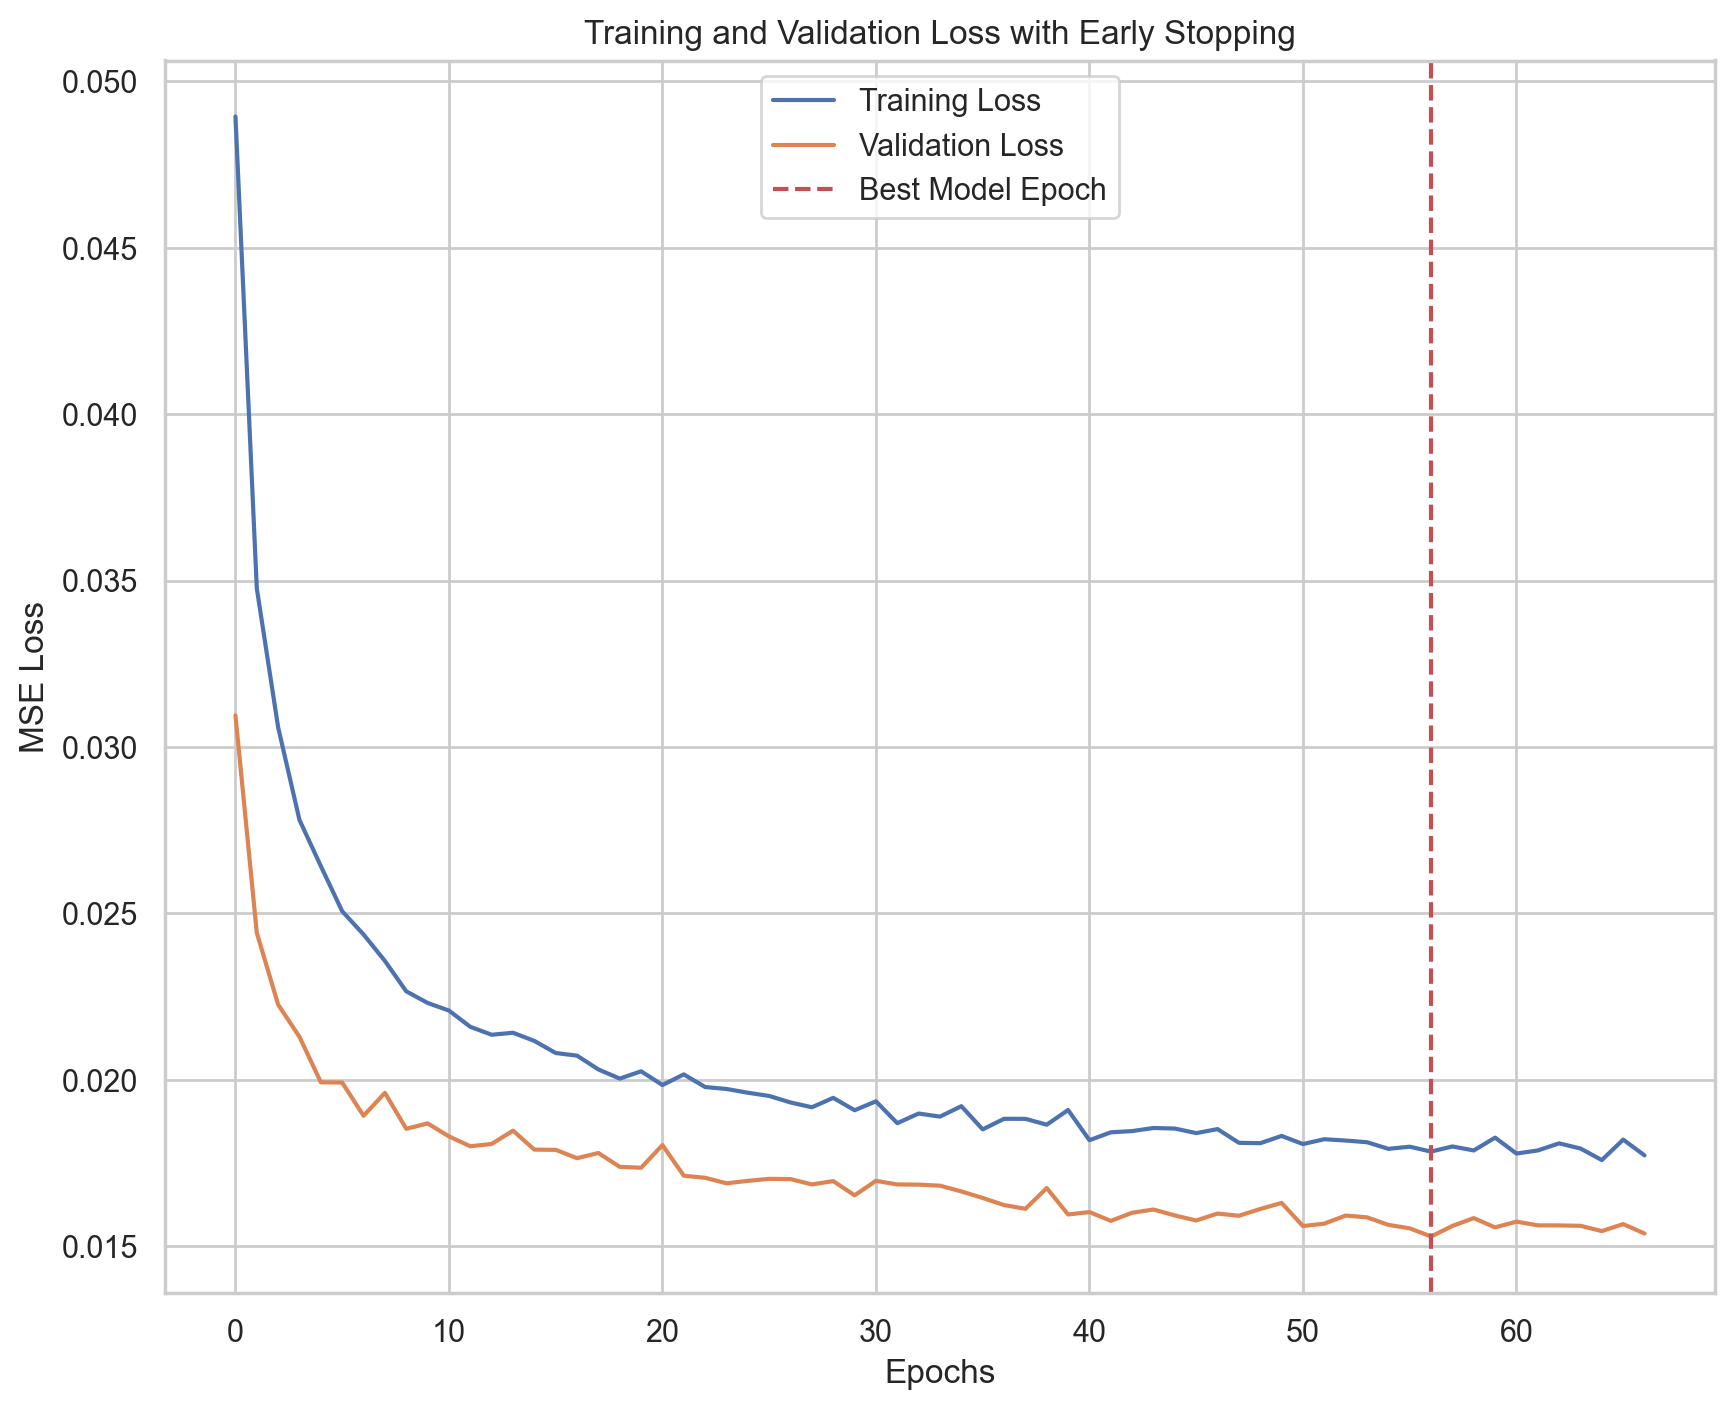

In [ ]:
if 'df_meta' not in locals() or df_meta.empty:
    print("df_meta not found or is empty. Please run the feature generation cell first.")
else:
    # 1. Define Features (X) and Target (y) using the final feature set
    feature_cols = [col for col in df_meta.columns if col not in ['target_id', 'model_source_str', 'prediction_index', 'tm_score']]
    X = df_meta[feature_cols]
    y = df_meta['tm_score']

    # 2. Split data into training and validation sets
    # Using a slightly larger validation set for a more stable signal
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # 3. Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    # 4. Create PyTorch Datasets and DataLoaders
    class RNADataset(Dataset):
        def __init__(self, features, labels):
            self.features = torch.tensor(features, dtype=torch.float32)
            self.labels = torch.tensor(labels.values, dtype=torch.float32).unsqueeze(1)
        def __len__(self): return len(self.features)
        def __getitem__(self, idx): return self.features[idx], self.labels[idx]

    train_dataset = RNADataset(X_train_scaled, y_train)
    val_dataset = RNADataset(X_val_scaled, y_val)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)

    # 5. Initialize Model, Loss, and a Regularized Optimizer
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    model = MetaLearnerNN(input_features=X_train_scaled.shape[1]).to(device)
    criterion = nn.MSELoss()
    # STRATEGY 3: Add weight_decay (L2 regularization) to the optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

    # 6. Training Loop with Early Stopping
    num_epochs = 100 # Set a high number, early stopping will find the optimum
    train_losses, val_losses = [], []

    # --- STRATEGY 4: Early Stopping Implementation ---
    best_val_loss = float('inf')
    patience = 10 # How many epochs to wait for improvement before stopping
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for features, labels in train_loader:
            features, labels = features.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * features.size(0)
        
        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)
        
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for features, labels in val_loader:
                features, labels = features.to(device), labels.to(device)
                outputs = model(features)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * features.size(0)
        
        epoch_val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)
        
        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {epoch_train_loss:.6f} | Val Loss: {epoch_val_loss:.6f}")
        
        # Early stopping logic
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            patience_counter = 0
            # Save the best model state
            torch.save(model.state_dict(), 'best_model.pth')
            print(f"  -> Validation loss improved. Saving best model.")
        else:
            patience_counter += 1
            print(f"  -> Validation loss did not improve. Patience: {patience_counter}/{patience}")
        
        if patience_counter >= patience:
            print("\n--- Early stopping triggered! ---")
            break
            
    # --- Load the best model and save it ---
    print("\nLoading the best performing model for final save.")
    model.load_state_dict(torch.load('best_model.pth'))
    
    MODEL_SAVE_PATH = 'meta_learner_model.pth'
    SCALER_SAVE_PATH = 'meta_learner_scaler.pkl'
    
    torch.save(model.state_dict(), MODEL_SAVE_PATH)
    joblib.dump(scaler, SCALER_SAVE_PATH)

    print(f"✅ Best model saved to {MODEL_SAVE_PATH}")
    print(f"✅ Scaler saved to {SCALER_SAVE_PATH}")

    # 7. Plotting the results
    plt.figure(figsize=(10, 8))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.axvline(x=len(val_losses)-patience-1, color='r', linestyle='--', label='Best Model Epoch')
    plt.title('Training and Validation Loss with Early Stopping')
    plt.xlabel('Epochs')
    plt.ylabel('MSE Loss')
    plt.legend()
    # plt.show()